In [33]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from scipy.optimize import minimize_scalar
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
from scipy.optimize import minimize
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.linear_model import Ridge
from time import time

CustomYeoJohnsonTransformer



In [34]:
class CustomYeoJohnsonTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, standardize=True):
        self.standardize = standardize
        self.lambdas_ = None
        self.mean_ = None
        self.std_ = None

    def _yeo_johnson_transform(self, x, lmbda):
        x = np.asarray(x)
        pos = x >= 0

        with np.errstate(all='ignore'):
            y = np.where(np.abs(lmbda) < 1e-8,
                           np.where(pos, np.log1p(x), -np.log1p(-x)),
                           np.where(pos,
                                    (np.power(x + 1, lmbda) - 1) / lmbda,
                                    (np.power(-x + 1, 2 - lmbda) - 1) / (2 - lmbda)))

        y = np.nan_to_num(y, nan=0.0, posinf=1e10, neginf=-1e10)
        return y

    def _find_optimal_lambda(self, x):
        def neg_log_likelihood(lmbda):
            y = self._yeo_johnson_transform(x, lmbda)
            if np.all(np.isnan(y)):
                return np.inf
            n = len(x)
            var = np.nanvar(y) + 1e-8
            loglike = -n/2 * np.log(var) + (lmbda - 1) * np.nansum(np.sign(x) * np.log1p(np.abs(x)))
            return -loglike

        try:
            res = minimize_scalar(neg_log_likelihood, bounds=(-2, 2), method='bounded')
            return res.x
        except:
            return 1.0

    def fit(self, X, y=None):
        X = check_array(X, ensure_2d=True, force_all_finite='allow-nan')
        X_filled = np.nan_to_num(X, nan=0.0)

        self.lambdas_ = np.array([self._find_optimal_lambda(X_filled[:, i])
                                 for i in range(X.shape[1])])

        if self.standardize:
            transformed = np.zeros_like(X_filled)
            for i in range(X.shape[1]):
                transformed[:, i] = self._yeo_johnson_transform(X_filled[:, i], self.lambdas_[i])

            self.mean_ = np.nanmean(transformed, axis=0)
            self.std_ = np.nanstd(transformed, axis=0)
            self.std_[self.std_ == 0] = 1.0

        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X, ensure_2d=True, force_all_finite='allow-nan')
        X_filled = np.nan_to_num(X, nan=0.0)

        transformed = np.zeros_like(X_filled)
        for i in range(X.shape[1]):
            transformed[:, i] = self._yeo_johnson_transform(X_filled[:, i], self.lambdas_[i])

        if self.standardize:
            transformed = (transformed - self.mean_) / self.std_

        transformed[np.isnan(X)] = np.nan
        return transformed

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)



CustomImputer


In [35]:
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self, num_strategy='median', cat_strategy='most_frequent'):

        self.num_strategy = num_strategy
        self.cat_strategy = cat_strategy
        self.num_stats_ = {}
        self.cat_stats_ = {}

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.num_cols_ = X.select_dtypes(include=['number']).columns
            self.cat_cols_ = X.select_dtypes(exclude=['number']).columns


        for col in self.num_cols_:
            if self.num_strategy == 'mean':
                self.num_stats_[col] = np.nanmean(X[col] if isinstance(X, pd.DataFrame) else np.nanmean(X[:, col]))
            elif self.num_strategy == 'median':
                self.num_stats_[col] = np.nanmedian(X[col] if isinstance(X, pd.DataFrame) else np.nanmedian(X[:, col]))
            elif self.num_strategy == 'mode':
                self.num_stats_[col] = stats.mode(X[col] if isinstance(X, pd.DataFrame) else X[:, col], nan_policy='omit').mode[0]
            else:
                self.num_stats_[col] = 0

        for col in self.cat_cols_:
            if self.cat_strategy == 'most_frequent':
                values, counts = np.unique(X[col][~pd.isna(X[col])], return_counts=True)
                self.cat_stats_[col] = values[np.argmax(counts)]
            else:
                self.cat_stats_[col] = 'missing'

        return self

    def transform(self, X):
        X = X.copy()

        for col in self.num_cols_:
            X[col] = X[col].fillna(self.num_stats_[col])


        for col in self.cat_cols_:
            X[col] = X[col].fillna(self.cat_stats_[col])


        return X

CustomOneHotEncoder

In [36]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, max_categories=20, min_frequency=None, handle_unknown='ignore', drop=None):
        self.max_categories = max_categories
        self.min_frequency = min_frequency
        self.handle_unknown = handle_unknown
        self.drop = drop
        self.categories_ = {}
        self.feature_names_out_ = []

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X = X.values

        n_samples, n_features = X.shape

        for i in range(n_features):
            values, counts = np.unique(X[:, i], return_counts=True)

            if self.min_frequency is not None:
                if isinstance(self.min_frequency, float):
                    min_count = self.min_frequency * n_samples
                else:
                    min_count = self.min_frequency
                mask = counts >= min_count
                values = values[mask]
                counts = counts[mask]

            if len(values) > self.max_categories:
                top_indices = np.argsort(counts)[-self.max_categories:]
                values = values[top_indices]

            self.categories_[i] = values

            if hasattr(X, 'columns'):
                base_name = X.columns[i]
                self.feature_names_out_.extend([f"{base_name}_{cat}" for cat in values])
            else:
                self.feature_names_out_.extend([f"feature_{i}_{cat}" for cat in values])

        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values

        n_samples, n_features = X.shape
        output = []

        for i in range(n_features):
            if i not in self.categories_:
                continue

            cats = self.categories_[i]
            encoded = np.zeros((n_samples, len(cats)))

            for j, cat in enumerate(cats):
                encoded[:, j] = (X[:, i] == cat).astype(int)

            if self.handle_unknown == 'ignore':
                pass
            else:
                unknown_mask = ~np.isin(X[:, i], cats)
                if np.any(unknown_mask):
                    raise ValueError(f"unknown cat in f {i}")

            if self.drop == 'first' and len(cats) > 1:
                encoded = encoded[:, 1:]

            output.append(encoded)

        result = np.hstack(output)

        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(result, columns=self.feature_names_out_)
        return result

    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_out_)

CustomScaler

In [37]:
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, method='zscore', with_mean=True, with_std=True,
                 feature_range=(0, 1), clip=False):
        self.method = method
        self.with_mean = with_mean
        self.with_std = with_std
        self.feature_range = feature_range
        self.clip = clip
        self._validate_params()

    def _validate_params(self):
        if self.method not in ['zscore', 'minmax', 'robust']:
            raise ValueError("method должен быть 'zscore', 'minmax' или 'robust'")
        if len(self.feature_range) != 2:
            raise ValueError("feature_range должен быть tuple (min, max)")
        if self.feature_range[0] >= self.feature_range[1]:
            raise ValueError("Min должен быть меньше max в feature_range")

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X = X.values

        self.n_features_in_ = X.shape[1]

        if self.method == 'zscore':
            if self.with_mean:
                self.mean_ = np.nanmean(X, axis=0)
            else:
                self.mean_ = np.zeros(X.shape[1])

            if self.with_std:
                self.scale_ = np.nanstd(X, axis=0)
                self.scale_[self.scale_ == 0] = 1.0  # \ 0
            else:
                self.scale_ = np.ones(X.shape[1])

        elif self.method == 'minmax':
            self.data_min_ = np.nanmin(X, axis=0)
            self.data_max_ = np.nanmax(X, axis=0)
            self.data_range_ = self.data_max_ - self.data_min_
            self.data_range_[self.data_range_ == 0] = 1.0  # \ 0

        elif self.method == 'robust':
            if self.with_mean:
                self.center_ = np.nanmedian(X, axis=0)
            else:
                self.center_ = np.zeros(X.shape[1])

            if self.with_std:
                q25 = np.nanpercentile(X, 25, axis=0)
                q75 = np.nanpercentile(X, 75, axis=0)
                self.scale_ = q75 - q25
                self.scale_[self.scale_ == 0] = 1.0
            else:
                self.scale_ = np.ones(X.shape[1])

        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values.copy()
        else:
            X = X.copy()

        if self.method == 'zscore':
            X -= self.mean_
            X /= self.scale_

        elif self.method == 'minmax':
            X = (X - self.data_min_) / self.data_range_
            X = X * (self.feature_range[1] - self.feature_range[0]) + self.feature_range[0]
            if self.clip:
                np.clip(X, self.feature_range[0], self.feature_range[1], out=X)

        elif self.method == 'robust':
            X -= self.center_
            X /= self.scale_

        if hasattr(self, 'input_is_df_') and self.input_is_df_:
            return pd.DataFrame(X, columns=self.feature_names_in_)
        return X

    def fit_transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.input_is_df_ = True
            self.feature_names_in_ = X.columns.tolist()
        return self.fit(X, y).transform(X)

CustomLinearRegression

In [38]:
class CustomLinearRegression(BaseEstimator, RegressorMixin):
    def __init__(self, method='analytical', learning_rate=0.01, max_iter=1000,
                 tol=1e-4, batch_size=32, regularization=None, alpha=1.0,
                 l1_ratio=0.5, p=2, random_state=None):
        """
        Кастомная линейная регрессия с разными методами обучения и регуляризациями.

        Параметры:
        ----------
        method : {'analytical', 'gradient', 'sgd'}, default='analytical'
            Метод оптимизации:
            - 'analytical' - аналитическое решение (нормальное уравнение)
            - 'gradient' - полный градиентный спуск
            - 'sgd' - стохастический градиентный спуск
        learning_rate : float, default=0.01
            Скорость обучения для градиентных методов
        max_iter : int, default=1000
            Максимальное количество итераций
        tol : float, default=1e-4
            Критерий остановки (изменение функции потерь)
        batch_size : int, default=32
            Размер батча для SGD
        regularization : {None, 'l1', 'l2', 'elasticnet', 'lp'}, default=None
            Тип регуляризации:
            - None: без регуляризации
            - 'l1': L1 (Lasso)
            - 'l2': L2 (Ridge)
            - 'elasticnet': ElasticNet (L1 + L2)
            - 'lp': Lp регуляризация
        alpha : float, default=1.0
            Коэффициент регуляризации
        l1_ratio : float, default=0.5
            Соотношение L1/L2 для ElasticNet (0-1)
        p : float, default=2
            Степень p для Lp регуляризации
        random_state : int, default=None
            Seed для генератора случайных чисел
        """
        self.method = method
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.batch_size = batch_size
        self.regularization = regularization
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.p = p
        self.random_state = random_state
    def score(self, X, y, metric='r2'):
        y_pred = self.predict(X)

        if metric == 'mse':
            return mean_squared_error(y, y_pred)
        elif metric == 'mae':
            return mean_absolute_error(y, y_pred)
        elif metric == 'r2':
            return r2_score(y, y_pred)
        elif metric == 'mape':
            return np.mean(np.abs((y - y_pred) / np.clip(np.abs(y), 1e-8, None))) * 100
        else:
            raise ValueError("Неизвестная метрика")


    def _add_intercept(self, X):
        return np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

    def _compute_loss(self, theta, X, y):
        residuals = X.dot(theta) - y
        mse = np.mean(residuals**2)

        if self.regularization is None:
            return mse

        reg_term = 0
        theta_no_intercept = theta[1:]

        if self.regularization == 'l1':
            reg_term = np.sum(np.abs(theta_no_intercept))
        elif self.regularization == 'l2':
            reg_term = np.sum(theta_no_intercept**2)
        elif self.regularization == 'elasticnet':
            l1_term = np.sum(np.abs(theta_no_intercept))
            l2_term = np.sum(theta_no_intercept**2)
            reg_term = self.l1_ratio * l1_term + (1 - self.l1_ratio) * l2_term
        elif self.regularization == 'lp':
            reg_term = np.sum(np.abs(theta_no_intercept)**self.p)

        return mse + self.alpha * reg_term

    def _compute_gradient(self, theta, X, y):
        residuals = X.dot(theta) - y
        grad = 2 * X.T.dot(residuals) / len(y)

        if self.regularization is None:
            return grad

        reg_grad = np.zeros_like(theta)
        theta_no_intercept = theta[1:]

        if self.regularization == 'l1':
            reg_grad[1:] = np.sign(theta_no_intercept)
        elif self.regularization == 'l2':
            reg_grad[1:] = 2 * theta_no_intercept
        elif self.regularization == 'elasticnet':
            l1_grad = np.sign(theta_no_intercept)
            l2_grad = 2 * theta_no_intercept
            reg_grad[1:] = self.l1_ratio * l1_grad + (1 - self.l1_ratio) * l2_grad
        elif self.regularization == 'lp':
            reg_grad[1:] = self.p * np.sign(theta_no_intercept) * np.abs(theta_no_intercept)**(self.p-1)

        return grad + self.alpha * reg_grad

    def _analytical_solution(self, X, y):
        if self.regularization is None:
            theta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
        elif self.regularization == 'l2':
            n_features = X.shape[1]
            I = np.eye(n_features)
            I[0, 0] = 0
            theta = np.linalg.pinv(X.T.dot(X) + self.alpha * I).dot(X.T).dot(y)
        else:
            theta = np.zeros(X.shape[1])
            theta = self._gradient_descent(X, y, theta)

        return theta

    def _gradient_descent(self, X, y, theta_init):
        theta = theta_init.copy()
        prev_loss = float('inf')

        for i in range(self.max_iter):
            grad = self._compute_gradient(theta, X, y)
            theta -= self.learning_rate * grad

            current_loss = self._compute_loss(theta, X, y)
            if abs(prev_loss - current_loss) < self.tol:
                break
            prev_loss = current_loss

        return theta

    def _stochastic_gradient_descent(self, X, y, theta_init):
        theta = theta_init.copy()
        prev_loss = float('inf')
        n_samples = X.shape[0]
        rng = np.random.RandomState(self.random_state)

        for i in range(self.max_iter):
            indices = rng.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for j in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[j:j+self.batch_size]
                y_batch = y_shuffled[j:j+self.batch_size]

                grad = self._compute_gradient(theta, X_batch, y_batch)
                theta -= self.learning_rate * grad

            current_loss = self._compute_loss(theta, X, y)
            if abs(prev_loss - current_loss) < self.tol:
                break
            prev_loss = current_loss

        return theta

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        X = self._add_intercept(X)

        if self.method == 'analytical':
            self.coef_ = self._analytical_solution(X, y)
        else:
            theta_init = np.zeros(X.shape[1])

            if self.method == 'gradient':
                self.coef_ = self._gradient_descent(X, y, theta_init)
            elif self.method == 'sgd':
                self.coef_ = self._stochastic_gradient_descent(X, y, theta_init)
            else:
                raise ValueError("Неизвестный метод оптимизации")

        self.intercept_ = self.coef_[0]
        self.coef_ = self.coef_[1:]
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        X = self._add_intercept(X)
        return X.dot(np.concatenate([[self.intercept_], self.coef_]))

In [39]:
def compare_with_sklearn(X_train, y_train, X_test, y_test, alpha=1.0):
    metrics = ['mse', 'mae', 'r2', 'mape']
    results = {}

    custom_start = time()
    custom_model = CustomLinearRegression(method='analytical', regularization='l2',
                                        alpha=alpha, random_state=42)
    custom_model.fit(X_train, y_train)
    custom_time = time() - custom_start

    results['custom'] = {'time': custom_time}
    for metric in metrics:
        results['custom'][metric] = custom_model.score(X_test, y_test, metric)


    sklearn_start = time()
    sklearn_model = Ridge(alpha=alpha, random_state=42)
    sklearn_model.fit(X_train, y_train)
    sklearn_time = time() - sklearn_start

    results['sklearn'] = {'time': sklearn_time}
    y_pred = sklearn_model.predict(X_test)
    results['sklearn']['mse'] = mean_squared_error(y_test, y_pred)
    results['sklearn']['mae'] = mean_absolute_error(y_test, y_pred)
    results['sklearn']['r2'] = r2_score(y_test, y_pred)
    results['sklearn']['mape'] = np.mean(np.abs((y_test - y_pred) /
                                       np.clip(np.abs(y_test), 1e-8, None))) * 100


    print("\nСравнение метрик:")
    print(f"{'Metric':<10}{'Custom':<15}{'Sklearn':<15}{'Difference':<15}")
    for metric in metrics:
        diff = results['custom'][metric] - results['sklearn'][metric]
        print(f"{metric:<10}{results['custom'][metric]:<15.4f}{results['sklearn'][metric]:<15.4f}{diff:<15.4f}")

    print(f"\nВремя обучения: Custom={custom_time:.4f}s, Sklearn={sklearn_time:.4f}s")

    return results

In [40]:
def print_metrics(y_true, y_pred):
    print(f"MSE:  {mean_squared_error(y_true, y_pred):.4f}")
    print(f"MAE:  {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R2:   {r2_score(y_true, y_pred):.4f}")
    print(f"MAPE: {np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100:.4f}%")

In [41]:
import numpy as np
from sklearn.metrics import mean_squared_error

def custom_k_fold_cv(model, X, y, n_splits=5, shuffle=True, random_state=None):
    """
    Кастомная K-Fold кросс-валидация с расчетом RMSE

    Параметры:
    ----------
    model : объект модели с методами fit/predict
    X : array-like, shape (n_samples, n_features)
        Матрица признаков
    y : array-like, shape (n_samples,)
        Вектор целевой переменной
    n_splits : int, default=5
        Количество фолдов
    shuffle : bool, default=True
        Перемешивать ли данные перед разбиением
    random_state : int, default=None
        Seed для воспроизводимости

    Возвращает:
    -----------
    rmse_scores : array, shape (n_splits,)
        Значения RMSE для каждого фолда
    """

    X = np.asarray(X)
    y = np.asarray(y)
    assert len(X) == len(y), "X и y должны иметь одинаковую длину"

    n_samples = len(X)
    indices = np.arange(n_samples)

    if shuffle:
        rng = np.random.RandomState(random_state)
        rng.shuffle(indices)

    fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=int)
    fold_sizes[:n_samples % n_splits] += 1
    current = 0
    splits = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_idx = indices[start:stop]
        train_idx = np.concatenate([indices[:start], indices[stop:]])
        splits.append((train_idx, test_idx))
        current = stop

    rmse_scores = []
    for i, (train_idx, test_idx) in enumerate(splits):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)

        print(f"Fold {i+1}: RMSE = {rmse:.4f}")

    print(f"\nСреднее RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
    return np.array(rmse_scores)



In [47]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print(f"Размер данных до удаления дубликатов: {len(train_data)}")
train_data = train_data.drop_duplicates()
print(f"Размер данных после удаления дубликатов: {len(train_data)}")

train_data = train_data[(train_data["RiskScore"] >= 0) & (train_data["RiskScore"] <= 100)]

X_train = train_data.drop(['RiskScore', 'ID', 'ApplicationDate'], axis=1, errors='ignore')
y_train = train_data['RiskScore']
X_test = test_data.drop(['ID', 'ApplicationDate'], axis=1, errors='ignore')

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

train_data.info()
train_data.head(6)
print(train_data.describe())

Размер данных до удаления дубликатов: 11017
Размер данных после удаления дубликатов: 10001
<class 'pandas.core.frame.DataFrame'>
Index: 9788 entries, 0 to 9999
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             9788 non-null   object 
 1   Age                         9788 non-null   float64
 2   AnnualIncome                9788 non-null   float64
 3   CreditScore                 9332 non-null   float64
 4   LoanAmount                  9332 non-null   float64
 5   LoanDuration                9788 non-null   float64
 6   MaritalStatus               9788 non-null   object 
 7   NumberOfDependents          9788 non-null   float64
 8   HomeOwnershipStatus         9788 non-null   object 
 9   MonthlyDebtPayments         9332 non-null   float64
 10  CreditCardUtilizationRate   9788 non-null   float64
 11  NumberOfOpenCreditLines     9788 non-null   float64
 12  Numb

In [50]:
missing_values_count = train_data.isnull().sum()
print(missing_values_count)

ApplicationDate                 0
Age                             0
AnnualIncome                    0
CreditScore                   456
LoanAmount                    456
LoanDuration                    0
MaritalStatus                   0
NumberOfDependents              0
HomeOwnershipStatus             0
MonthlyDebtPayments           456
CreditCardUtilizationRate       0
NumberOfOpenCreditLines         0
NumberOfCreditInquiries         0
DebtToIncomeRatio               0
BankruptcyHistory             456
LoanPurpose                   456
PreviousLoanDefaults            0
PaymentHistory                  0
LengthOfCreditHistory           0
SavingsAccountBalance           0
CheckingAccountBalance        456
TotalAssets                   456
TotalLiabilities                0
MonthlyIncome                   0
UtilityBillsPaymentHistory      0
JobTenure                       0
EmploymentStatus                0
EducationLevel                  0
Experience                      0
NetWorth      

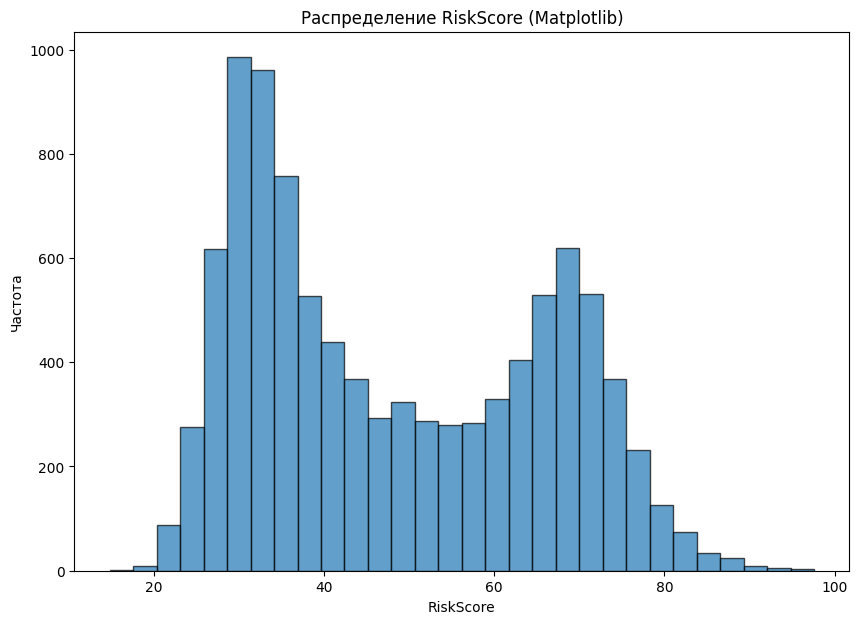

count    9788.000000
mean       48.325333
std        17.233659
min        14.841417
25%        32.717486
50%        44.180868
75%        65.090711
max        97.597249
Name: RiskScore, dtype: float64


In [51]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 7))
plt.hist(train_data["RiskScore"], bins=30, edgecolor="black", alpha=0.7)
plt.title("Распределение RiskScore (Matplotlib)")
plt.xlabel("RiskScore")
plt.ylabel("Частота")
plt.show()
print(train_data["RiskScore"].describe())

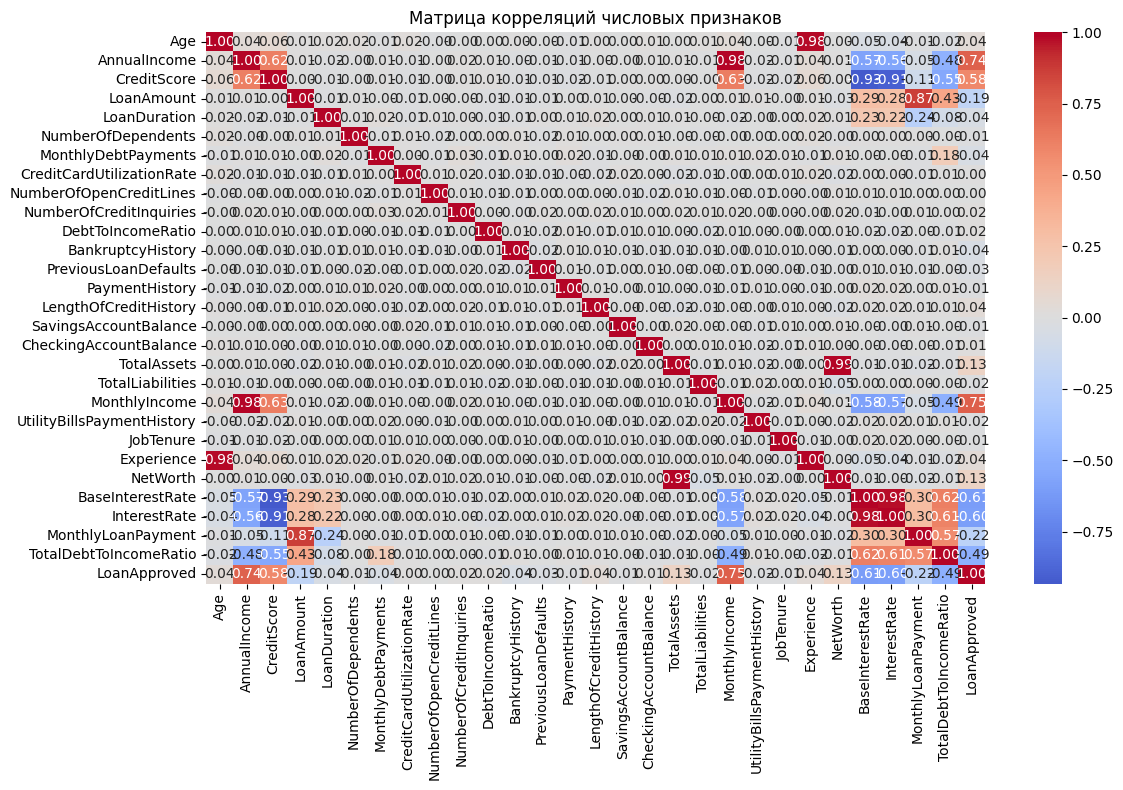

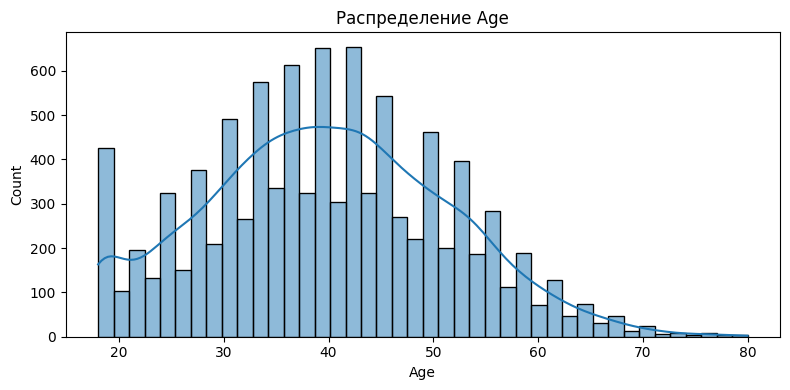

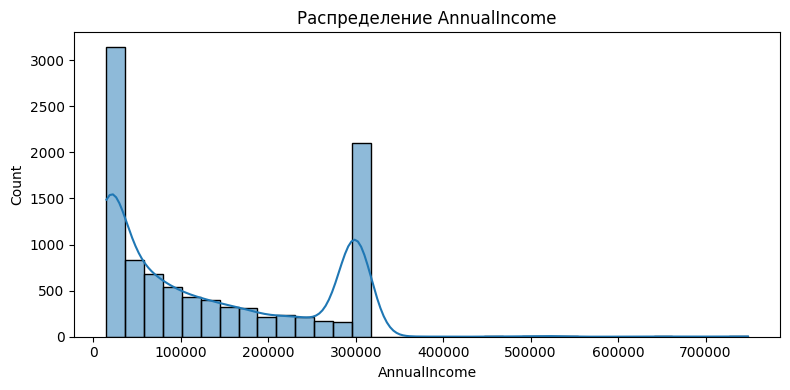

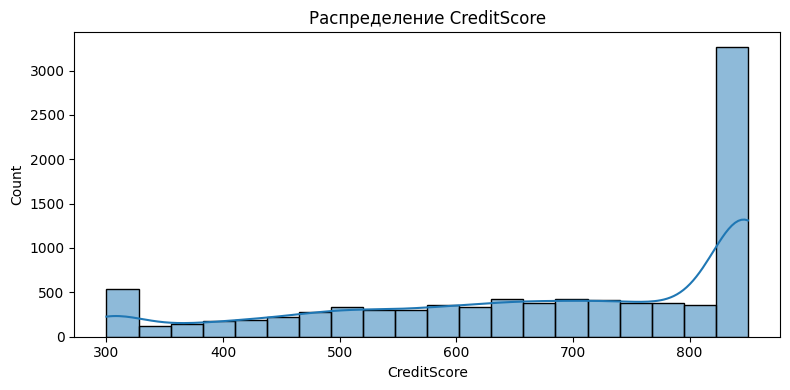

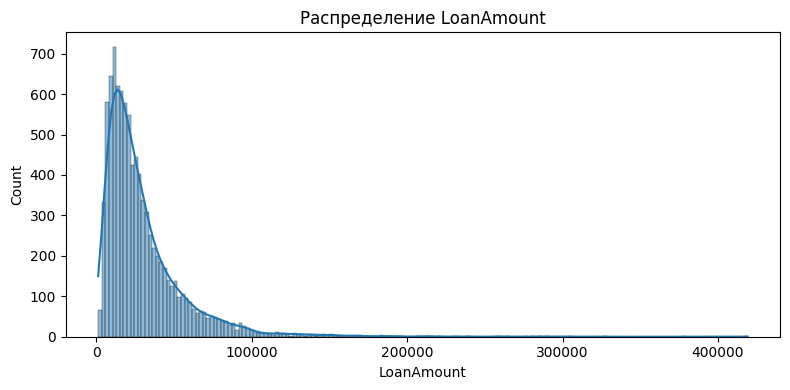

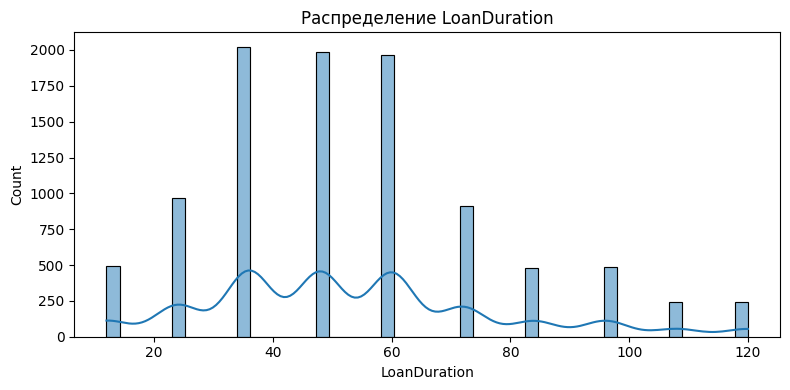

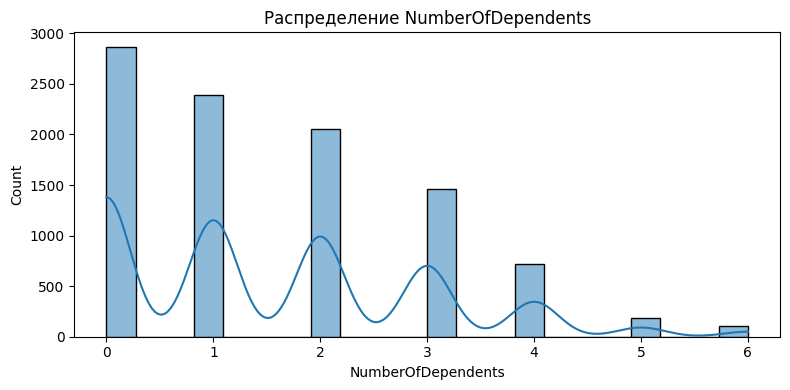

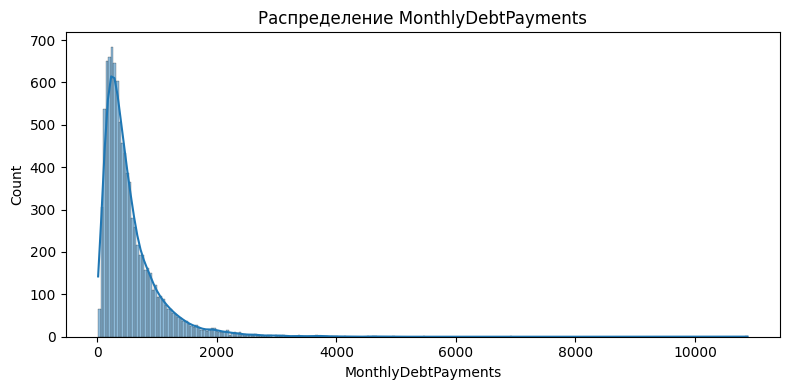

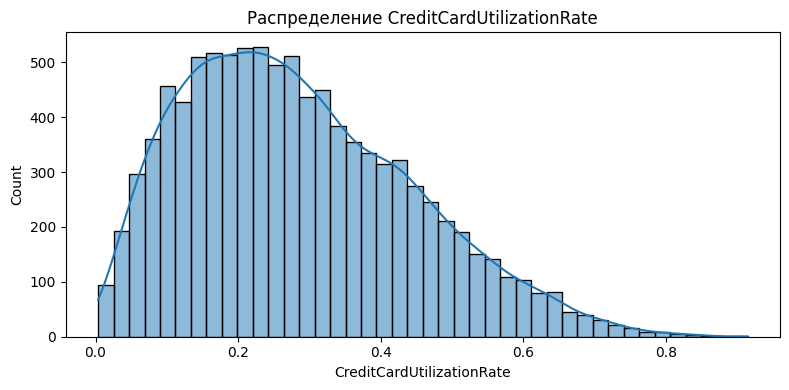

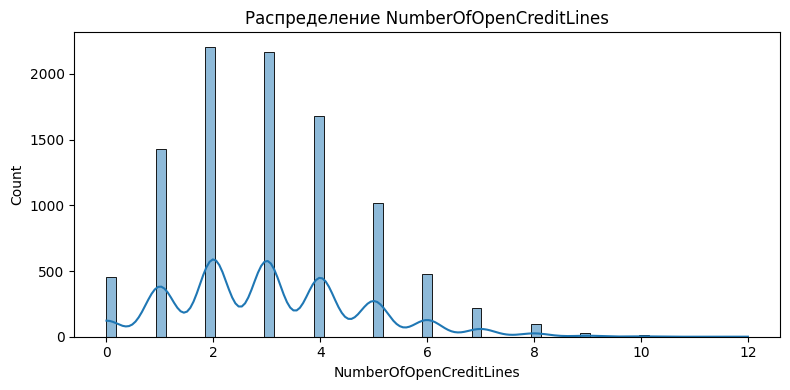

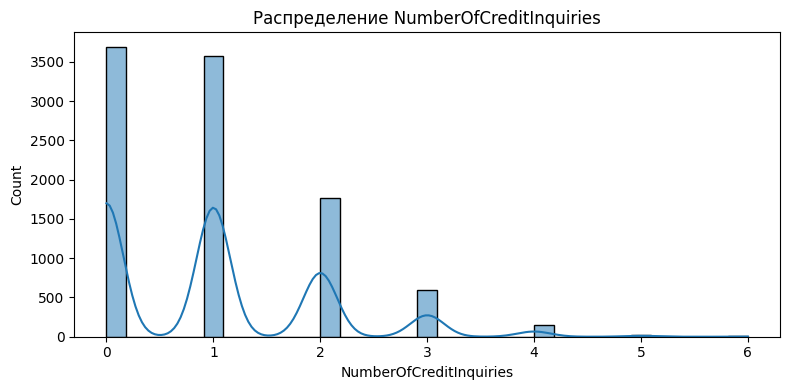

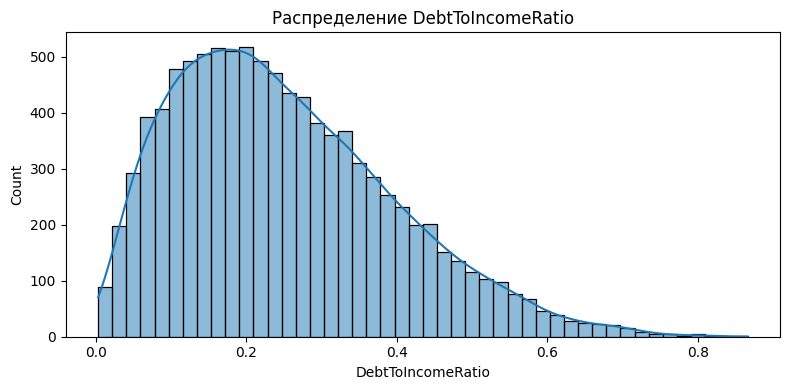

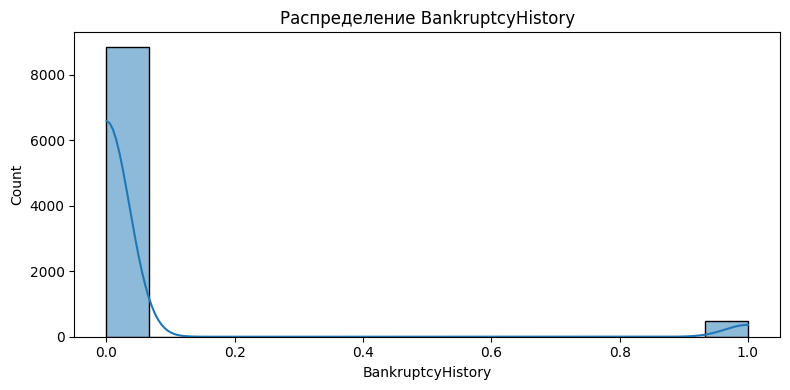

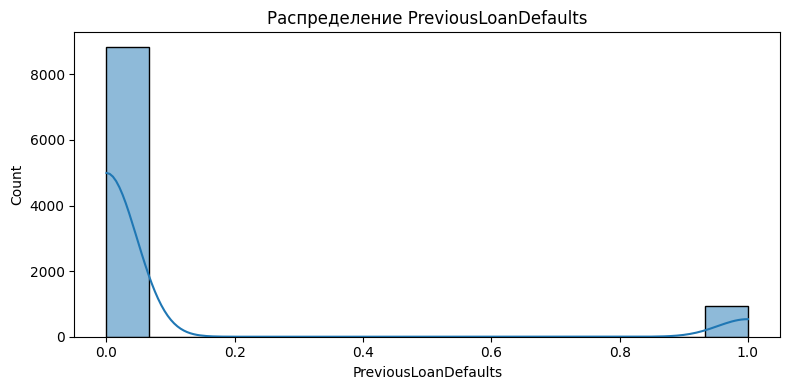

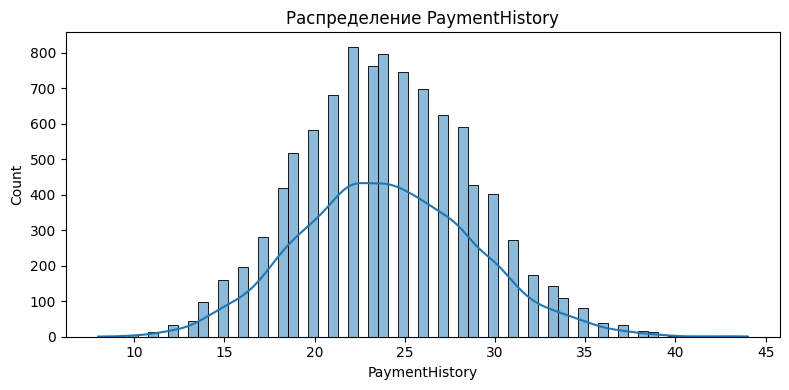

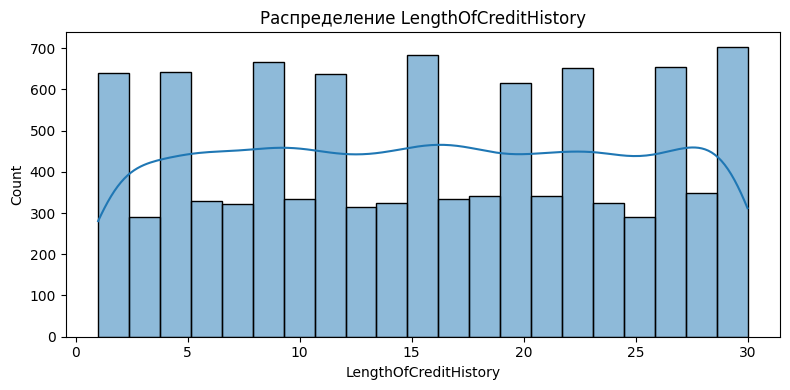

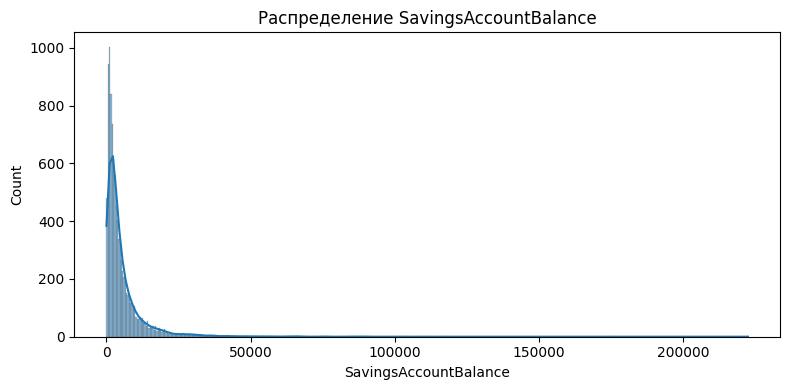

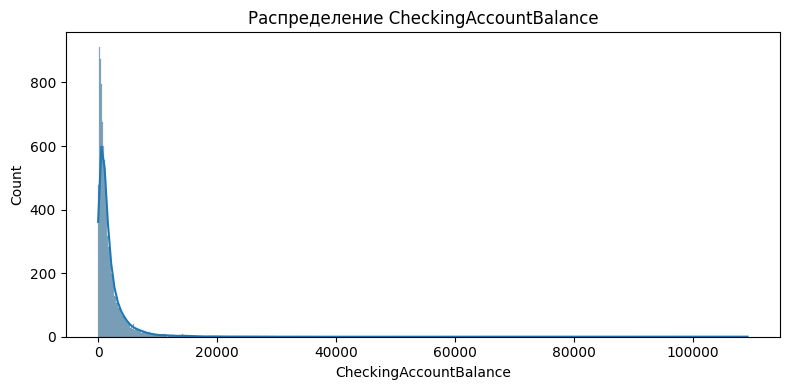

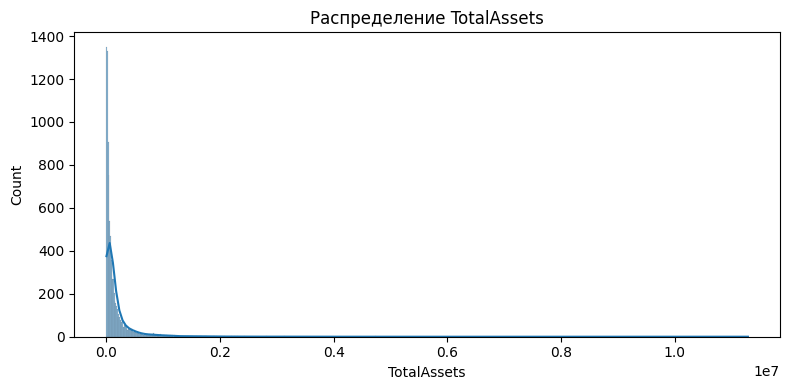

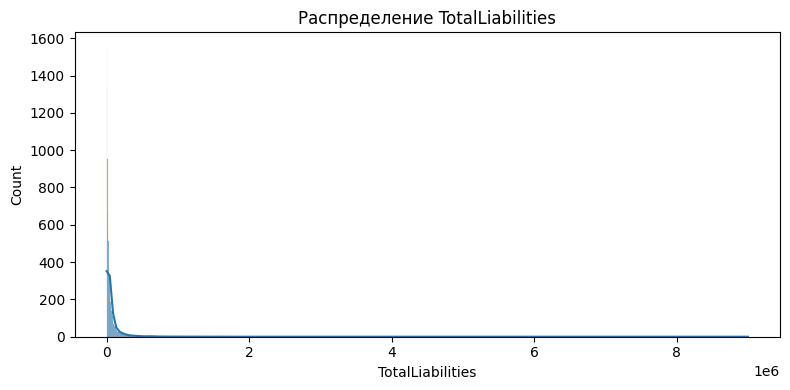

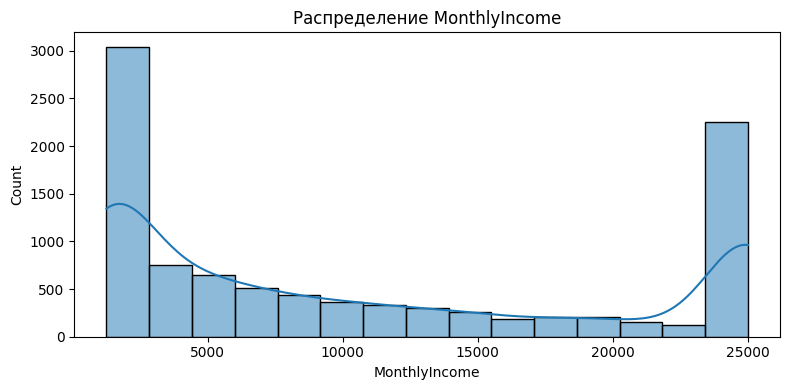

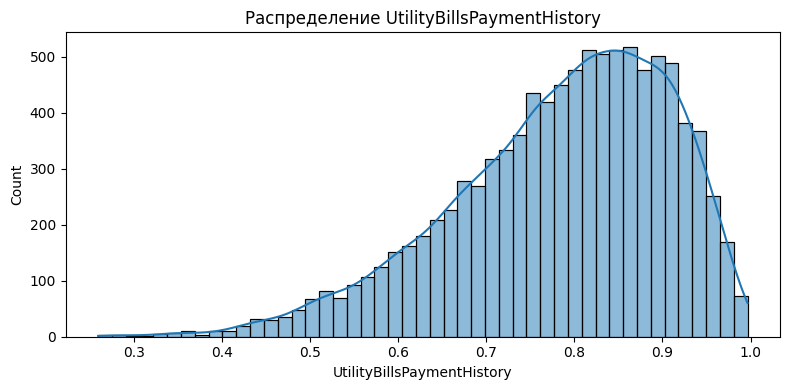

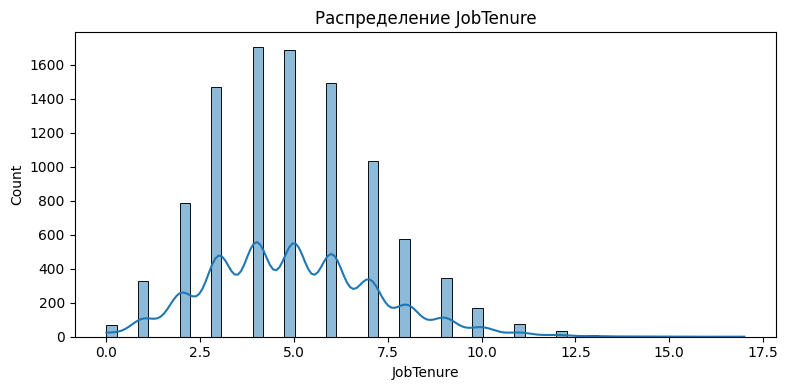

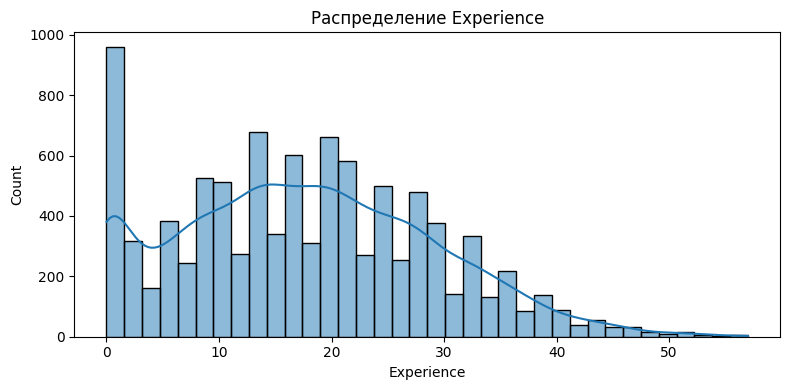

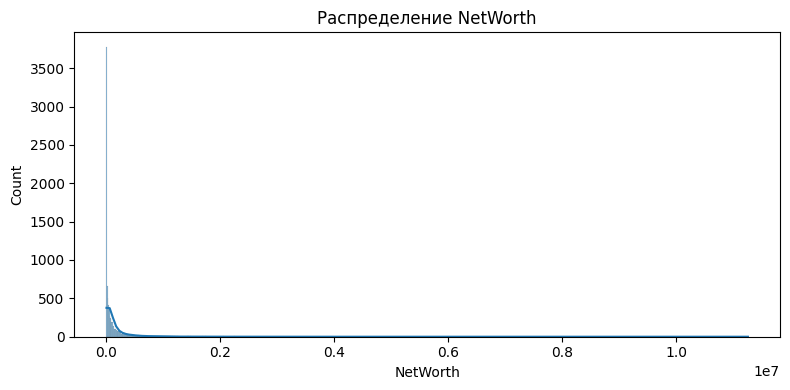

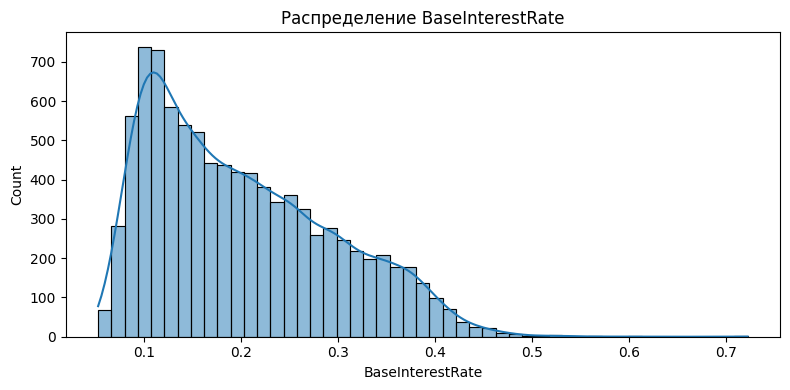

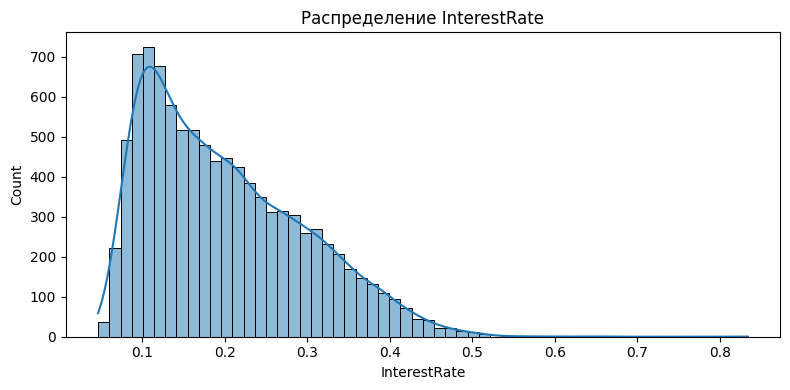

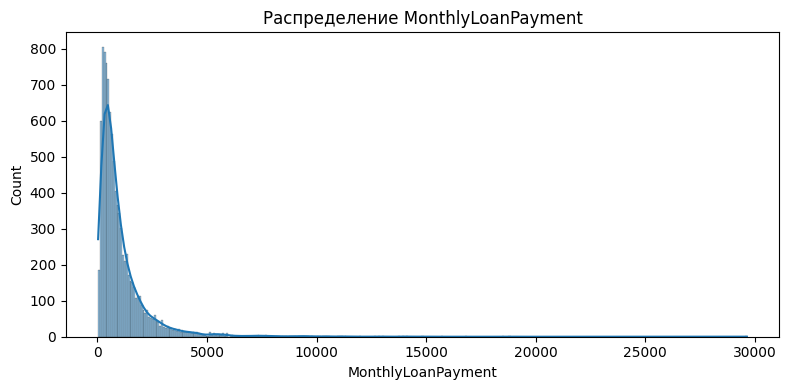

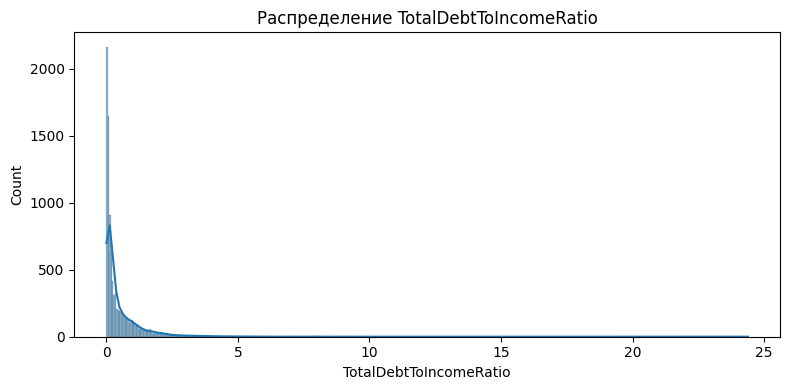

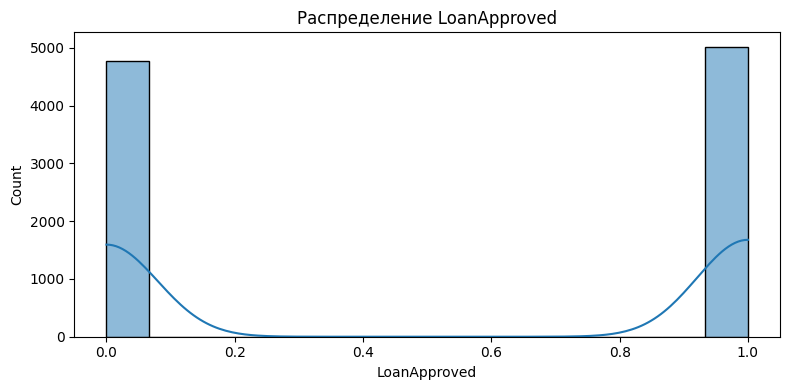

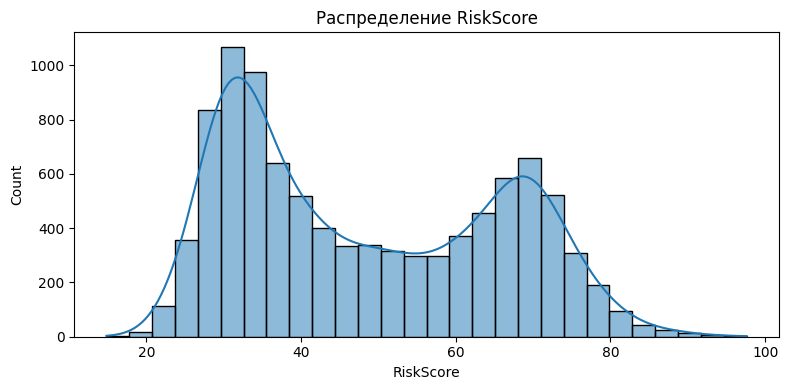

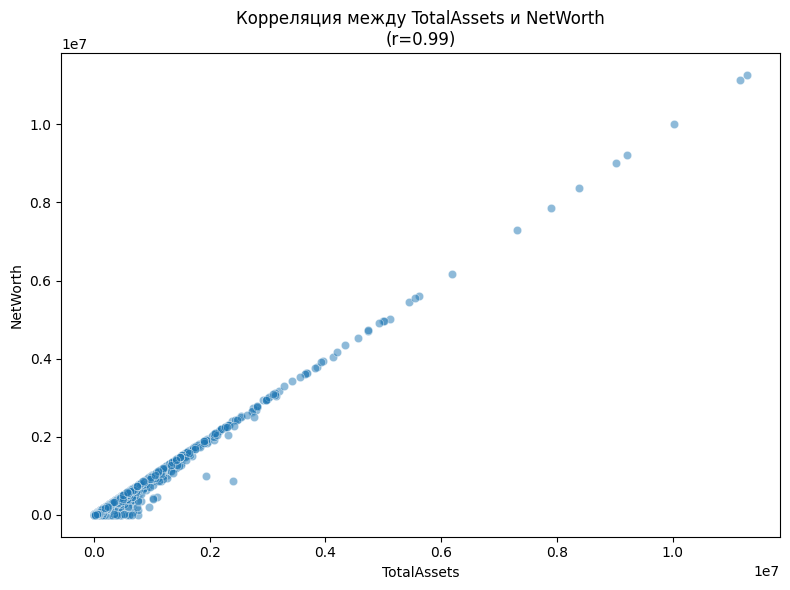

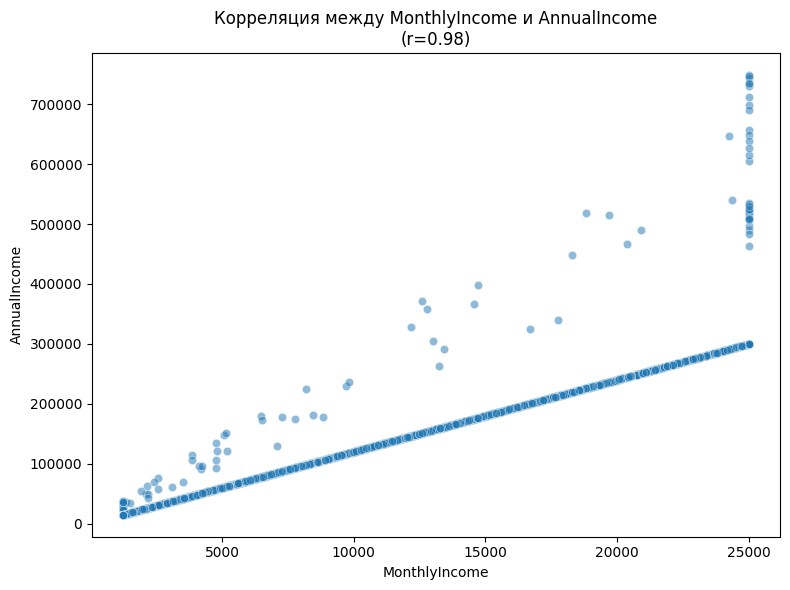

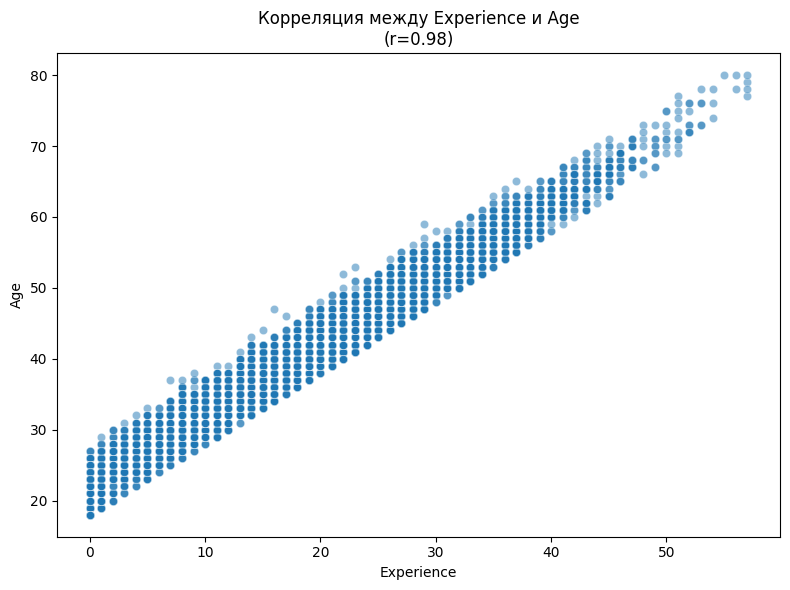

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
corr_matrix = train_data[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Матрица корреляций числовых признаков')
plt.tight_layout()
plt.show()

numeric_data = train_data.select_dtypes(include=['int64', 'float64'])
for col in numeric_data.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(numeric_data[col], kde=True)
    plt.title(f'Распределение {col}')
    plt.tight_layout()
    plt.show()

top_corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates()
top_corr_pairs = top_corr_pairs[top_corr_pairs < 1.0].head(3)

for pair in top_corr_pairs.index:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=train_data, x=pair[0], y=pair[1], alpha=0.5)
    plt.title(f'Корреляция между {pair[0]} и {pair[1]}\n(r={corr_matrix.loc[pair[0], pair[1]]:.2f})')
    plt.tight_layout()
    plt.show()



In [54]:


numeric_transformer = Pipeline(steps=[
    ('imputer', CustomImputer(num_strategy='median', cat_strategy='most_frequent')),
    ('gaussian', CustomYeoJohnsonTransformer(standardize=True)),
    ('scaler', CustomScaler(method='zscore'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', CustomImputer(num_strategy='median', cat_strategy='most_frequent')),
    ('onehot', CustomOneHotEncoder(max_categories=15, min_frequency=0.01))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CustomLinearRegression(
        method='analytical',
        regularization='l2',
        alpha=10.0,
        random_state=42
    ))
])




model.fit(X_train, y_train)
train_pred = model.predict(X_train)
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, train_pred)):.2f}")

test_pred = model.predict(X_test)
test_pred = np.clip(test_pred, 0, 100)
pd.DataFrame({'ID': test_data['ID'], 'RiskScore': test_pred}).to_csv('submission.csv', index=False)



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Train RMSE: 4.05


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


numeric_transformer_with_poly = Pipeline(steps=[
    ('imputer', CustomImputer(num_strategy='median', cat_strategy='most_frequent')),
    ('gaussian', CustomYeoJohnsonTransformer(standardize=True)),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', CustomScaler())
])

preprocessor_with_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_with_poly, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


poly_model = Pipeline(steps=[
    ('preprocessor', preprocessor_with_poly),
    ('regressor', LinearRegression())
])


poly_model.fit(X_train, y_train)

train_pred_poly = poly_model.predict(X_train)
test_pred_poly = poly_model.predict(X_test)

print("\nМетрики на тренировочных данных:")
print_metrics(y_train, train_pred_poly)

print("\nМетрики на тестовых данных:")
print_metrics(test_pred, test_pred_poly)


test_pred_final =poly_model.predict(X_test)
test_pred_final = np.clip(test_pred_final, 0, 100)

output = pd.DataFrame({
    'ID': test_data['ID'],
    'RiskScore': test_pred_final
})

import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
filename = f'submission_poly_ridge_{timestamp}.csv'

output.to_csv(filename, index=False)
print(f"Предсказания сохранены в файл: {filename}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Метрики на тренировочных данных:
MSE:  11.5045
MAE:  2.6166
R2:   0.9613
MAPE: 6.0757%

Метрики на тестовых данных:
MSE:  4.6960
MAE:  1.6746
R2:   0.9836
MAPE: 3.8256%
Предсказания сохранены в файл: submission_poly_ridge_20250507_1902.csv


В качетсве небольшого вывода могу сказать, что в целом мсе хороший.Для понижения можно попробовать преобразование бокса кокса либо двух трех кратное логарифминрование. также если не использовать ridge то можно было бы поиграть с например PCA или более глубокий инжиниринг фичей(добавление новых, удаление старых в зависимости от корреляции с целевой переменной, огранисение на размер после z score и тд). Я тут ансамблирование еще пробовал с нелинейными методами, тоже интересно, но потом уидел что по тз нельзя, по итогу лучшая модель это поли регрессия со второй степенью)
